# The Relationship Between Commodity Prices, Their Futures Trading Volumes, and Average Global Temperature

**By York Wang**

It is not implausible that the trading volumes of a commodity's futures contracts would be influenced by prior movements in the commodity's price itself. As futures contracts are utilized in hedging, it would make sense for commodity consumers to protect against potential upswings in commodity prices. Although there countless numbers of factors that can influence a commodity's prices and the trading volume of its futures, I wanted to see if there was a direct relationship between the two.

Specifically, I will be looking at agricultural commodities like cotton and wheat. In addition to examining the relationship between commodities prices and the trading volumes of their respective futures, I am also looking to see whether the global average temperature has any effect on the trading volumes of commodity futures, as one would expect the risk of climate change to be hedged against through futures contracts — which is why I've limited the commodities I'm looking at to agricultural ones.


The data I will be using will consist of:
- Monthly average global temperature deviations from the 1951-1980 mean
- Monthly trading volumes of agricultural commodities futures
- Monthly global prices for specified commodities

In [1]:
# Packages needed to run 

import pandas as pd 
# DataFrame package

import matplotlib.pyplot as plt
# Plotting our data

import statsmodels.formula.api as sm
# Used for simple linear regressions

import seaborn as sns #statistical graphs


## I. Importing and Cleaning the Data

### i. Importing and Cleaning Global Temperature Data
I am importing global temperature data from Datahub.io, a site where certain datasets are already curated and cleaned up for public use.

For this data, I will need to isolate the proper data source and restrict the time frame to match that of my commodities data.

In [2]:
# importing global temperature data

url = "https://pkgstore.datahub.io/core/global-temp/monthly_csv/data/5c846179d4938961e3f7515a26bf9976/monthly_csv.csv"
raw_temp = pd.read_csv(url)
raw_temp.head()

,Source,Date,Mean
0,GCAG,2016-12-15,0.7895
1,GISTEMP,2016-12-15,0.8100
2,GCAG,2016-11-15,0.7504
3,GISTEMP,2016-11-15,0.9300
4,GCAG,2016-10-15,0.7292


In [3]:
grouped_data = raw_temp.groupby("Source")
# There is data from two different sources for each month
# We try to utilize only data from "GISTEMP", which is a NASA source

temp = grouped_data.get_group("GISTEMP")
# We create a new dataframe with only "GISTEMP" data

temp = temp.drop(temp.index[144:])
# Since our historical data for futures trading volumes only goes back
# to January 2005, we drop all data from before January 2005.

temp = temp.reindex(index = temp.index[::-1])
# We want to flip the data around so that it's in chronological order.

temp = temp.drop("Source", axis = 1)
# We no longer need the data source

temp = temp.rename(columns = {"Mean": "MeanTemperatureDeviation"})

df = temp
# We'll use this as our main dataframe

df = df.reset_index()
# Resetting our index so that it's no longer funky

df = df.drop("index", axis = 1)
# Dropping the old index

df = df.reset_index()

# df.head()
# Input to see if our DataFrame looks the way we want it to

### ii. Importing and Cleaning Futures Trading Volume Data

This data is pulled by hand from _[Intercontinental Exchange](https://www.theice.com/marketdata/reports/8)_. I have cleaned the data up and uploaded it as a CSV to my Github.

In [4]:
url2 = "https://raw.githubusercontent.com/yorktruewang/data-bootcamp/master/Final%20Project/Commodity%20Futures%20Volumes.csv"
# Reading in our monthy futures trading volume historical data

f_v = pd.read_csv(url2)

f_v.head()
# Checking to see if the starting month is January 2005

f_v = f_v.rename(columns = {"Unnamed: 0": "Date"})

f_v.tail()
# Checking to see if the ending month is December 2016

# We need to drop the last 16 rows of our dataframe to match the dates

f_v = f_v.drop(f_v.index[144:])
# We should have the same number of rows, so we can use 144 as well

f_v = f_v.drop(axis = 1, columns = "PULP")
# Dropping "PULP" because its data ends somewhere within the time span.

# f_v.tail()
# Enter this command to see that our time span matches

In [5]:
# Manually adding trading volumes to the centralized dataframe

coffee = f_v["COFFEE"]
df["coffee"] = coffee

sugar = f_v["SUGAR"]
df["sugar"] = sugar

cotton = f_v["COTTON"]
df["cotton"] = cotton

fcoj = f_v["FCOJ"]
df["fcoj"] = fcoj

cocoa = f_v["COCOA"]
df["cocoa"] = cocoa

mg = f_v["METALS & GRAINS"]
df["grains proxy"] = mg

### iii. Importing and Cleaning Global Monthly Prices for Select Commodities

The commodities we've chosen are sugar, cocoa, cotton, and grains. We are limited in the number of commodities due to a lack of publicly-available monthly data on futures trading volumes and a lack of global monthly price data on other commodities (coffee, frozen concentrated orange juice).

Here, we pull the data from the IMF. Because it is all organized in the same way, we can write a function to quickly clean the data for us.

In addition, I've created individual DataFrames for each commodity so that the main DataFrame is not too populated.

In [6]:
# Our global price indices are all from the IMF, and thus have the same file structure
# Let's automate the process of cleaning the data

WHEAT ="https://raw.githubusercontent.com/yorktruewang/data-bootcamp/master/Final%20Project/WHEAT%20INDEX.csv"
COCOA = "https://raw.githubusercontent.com/yorktruewang/data-bootcamp/master/Final%20Project/COCOA%20INDEX.csv"
SUGAR = "https://raw.githubusercontent.com/yorktruewang/data-bootcamp/master/Final%20Project/SUGAR%20INDEX.csv"
COTTON = "https://raw.githubusercontent.com/yorktruewang/data-bootcamp/master/Final%20Project/COTTON%20INDEX.csv"

def clean(url, name):
    placeholder = pd.read_csv(url)
    # Import data
    
    placeholder.columns = ["Date", name]
    # Rename columns
    
    placeholder = placeholder.drop(placeholder.index[0:300])
    # Strip data before our range
    
    placeholder = placeholder.drop(placeholder.index[144:449])
    # Strip data after our range
    
    placeholder = placeholder.reset_index()
    # Reset the index so we can add the values to df
    
    placeholder = placeholder.drop("index", axis = 1)
    # Drop the old index
    
    df[name] = placeholder[name]
    # Place into df

# Manually clean the price indices
clean(SUGAR, "sugarindex")
clean(COTTON, "cottonindex")
clean(COCOA, "cocoaindex")

# Manually create new dataframes for each commodity
sugardf = pd.DataFrame({"sugar":df["sugar"], "sugarindex": df["sugarindex"]})
cottondf = pd.DataFrame({"cotton":df["cotton"], "cottonindex": df["cottonindex"]})
cocoadf = pd.DataFrame({"cocoa":df["cocoa"], "cocoaindex": df["cocoaindex"]})

Here we continue cleaning the data. This next section of code comprises of a function written to calculate the percentage change in commodity prices or futures trading volume from the previous month.

The other function written here is one that creates a column of "lagging" data in the DataFrame. In the case that markets aren't truly efficient, we take into consideration the possibility of futures contracts being bought one month after the commodity prices have begun to rise.

In [7]:
def percentage_calc(table, column, security):

    futures_change = [0]

    for x in range(143):
        y = x + 1
        value = (table.iloc[y][column]/table.iloc[x][column])-1
        futures_change.append(value)

    table[security] = futures_change

percentage_calc(sugardf, "sugar", "futures")
percentage_calc(cottondf, "cotton", "futures")
percentage_calc(cocoadf, "cocoa", "futures")

percentage_calc(sugardf, "sugarindex", "price")
percentage_calc(cottondf, "cottonindex", "price")
percentage_calc(cocoadf, "cocoaindex", "price")

def lagging_calc(table, column, security):

    futures_change = [0,0]

    for x in range(142):
        y = x + 1
        value = (table.iloc[y][column]/table.iloc[x][column])-1
        futures_change.append(value)

    table[security] = futures_change
    
lagging_calc(sugardf, "sugar", "lagging_futures")
lagging_calc(cottondf, "cotton", "lagging_futures")
lagging_calc(cocoadf, "cocoa", "lagging_futures")

lagging_calc(sugardf, "sugarindex", "lagging_price")
lagging_calc(cottondf, "cottonindex", "lagging_price")
lagging_calc(cocoadf, "cocoaindex", "lagging_price")

# cottondf.head()
# Input code to see if a sample DataFrame that we created

## II. Identifying Possible Correlations between Prices and Futures Trading Volume

Refer to section iv. for discussion of the correlations results.

### i. Sugar


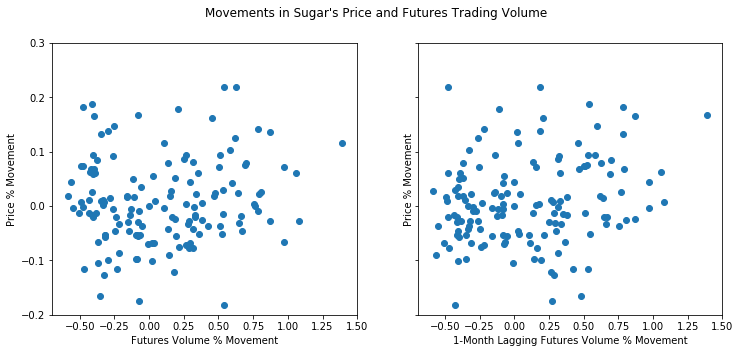

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (12,5))

fig.suptitle("Movements in Sugar's Price and Futures Trading Volume")


ax1.scatter(sugardf["futures"], sugardf["price"])

ax1.set_xlabel('Futures Volume % Movement')
ax1.set_ylabel('Price % Movement')
ax1.set_ylim(-0.2,0.3)

ax2.scatter(sugardf["lagging_futures"], sugardf["price"])

ax2.set_xlabel('1-Month Lagging Futures Volume % Movement')
ax2.set_ylabel('Price % Movement')

plt.show()

##### a. Regression of Price Movements on Futures Trading Volume Movements

In [9]:
mod = sm.ols('price ~ futures', data=sugardf)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.634
Date:                Tue, 15 May 2018   Prob (F-statistic):              0.203
Time:                        00:11:20   Log-Likelihood:                 163.15
No. Observations:                 144   AIC:                            -322.3
Df Residuals:                     142   BIC:                            -316.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0065      0.007      0.970      0.3

##### b. Regression of Price Movements on 1-Month Lagging Futures Trading Volume Movements

In [10]:
mod = sm.ols('futures ~ lagging_price', data=sugardf)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                futures   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     3.463
Date:                Tue, 15 May 2018   Prob (F-statistic):             0.0648
Time:                        00:11:20   Log-Likelihood:                -82.244
No. Observations:                 144   AIC:                             168.5
Df Residuals:                     142   BIC:                             174.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0975      0.036      2.695

### ii. Cocoa

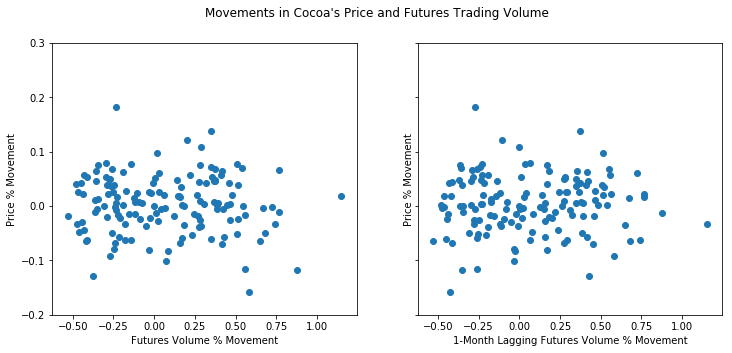

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (12,5))

fig.suptitle("Movements in Cocoa's Price and Futures Trading Volume")


ax1.scatter(cocoadf["futures"], cocoadf["price"])

ax1.set_xlabel('Futures Volume % Movement')
ax1.set_ylabel('Price % Movement')
ax1.set_ylim(-0.2,0.3)

ax2.scatter(cocoadf["lagging_futures"], cocoadf["price"])

ax2.set_xlabel('1-Month Lagging Futures Volume % Movement')
ax2.set_ylabel('Price % Movement')

plt.show()

##### a. Regression of Price Movements on Futures Trading Volume Movements

In [12]:
mod = sm.ols('price ~ futures', data=cocoadf)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.3419
Date:                Tue, 15 May 2018   Prob (F-statistic):              0.560
Time:                        00:11:20   Log-Likelihood:                 218.49
No. Observations:                 144   AIC:                            -433.0
Df Residuals:                     142   BIC:                            -427.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0046      0.005      1.025      0.3

##### b. Regression of Price Movements on 1-Month Lagging Futures Trading Volume Movements

In [13]:
mod = sm.ols('futures ~ lagging_price', data=cocoadf)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                futures   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.107
Date:                Tue, 15 May 2018   Prob (F-statistic):              0.295
Time:                        00:11:21   Log-Likelihood:                -54.770
No. Observations:                 144   AIC:                             113.5
Df Residuals:                     142   BIC:                             119.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0655      0.030      2.197

### iii. Cotton

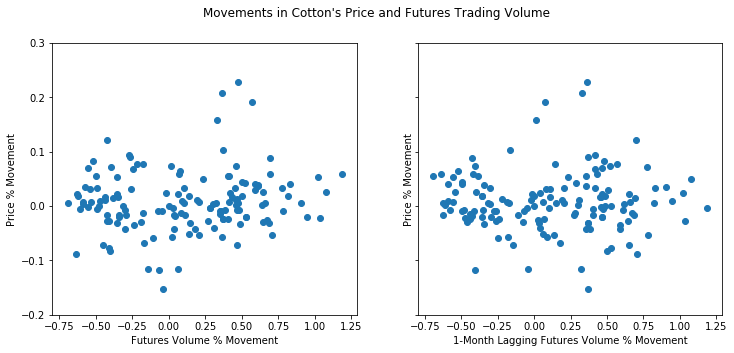

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (12,5))

fig.suptitle("Movements in Cotton's Price and Futures Trading Volume")


ax1.scatter(cottondf["futures"], cottondf["price"])

ax1.set_xlabel('Futures Volume % Movement')
ax1.set_ylabel('Price % Movement')
ax1.set_ylim(-0.2,0.3)

ax2.scatter(cottondf["lagging_futures"], cottondf["price"])

ax2.set_xlabel('1-Month Lagging Futures Volume % Movement')
ax2.set_ylabel('Price % Movement')

plt.show()

##### a. Regression of Price Movements on Futures Trading Volume Movements

In [15]:
mod = sm.ols('price ~ futures', data=cottondf)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     3.041
Date:                Tue, 15 May 2018   Prob (F-statistic):             0.0834
Time:                        00:11:21   Log-Likelihood:                 196.93
No. Observations:                 144   AIC:                            -389.9
Df Residuals:                     142   BIC:                            -383.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0029      0.005      0.550      0.5

##### b. Regression of Price Movements on 1-Month Lagging Futures Trading Volume Movements

In [16]:
mod = sm.ols('futures ~ lagging_price', data=cottondf)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                futures   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.1709
Date:                Tue, 15 May 2018   Prob (F-statistic):              0.680
Time:                        00:11:22   Log-Likelihood:                -90.653
No. Observations:                 144   AIC:                             185.3
Df Residuals:                     142   BIC:                             191.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.1069      0.038      2.796

### iv. Discussion

So the results are pretty disappointing, given that we had hoped to see correlations between the price and trading volume movements of commodities and their futures contrats. For each commodity, we graphed two scatterplots. 
* The first scatterplot (left-hand side) of each commodity's price/trading volume movements looked for positive linear correlation between the present price movements and present trading volume movements. This works under the assumption that markets are perfectly efficient, and that market participants will instantly begin purchasing (selling) futures contracts to hedge when prices begin to move upward (downward).
* The second scatterplot (right-hand side) of each commodity's price/trading volume movements looked for positive linear correlation between present price movements and 1 month-lagged trading volume movements. We thought that, in the case that markets are not perfectly efficient (as they are not in the real world), market participants would need a fair amount of time to recognize when the prices began moving. We used a lag period of 1 month because we felt that 30 days was enough time for participants to notice price changes and decide whether to engage in buying/selling contracts.

The two regressions calculated for both combinations of variables for each commodity were incredibly uncorrelated. The R-squared values yieled attest to this. From this, we can say that the relationship between 1) present prices and present futures trading volumes, and 2) present prices and 1 month-lagged futures trading volumes is statistically insignificant. 

## III. Commodity Price Relationships with Average Global Temperature Deviations

Here, we try to see if there is any relationship between average global temperatures and futures trading volumes. Although actual crop harvests are difficult to project, it may be easier to hedge based on changes in temperature. In this case, our temperature dataset acts as a proxy for the overall climate change.

### i. Mean Temperature Deviation Growth Over Time

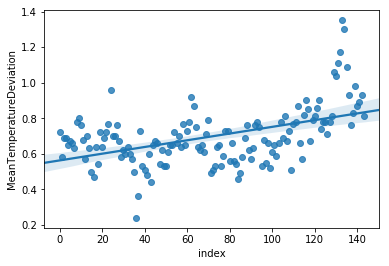

In [17]:
sns.regplot(x="index", y="MeanTemperatureDeviation", data=df)

In [18]:
mod = sm.ols('MeanTemperatureDeviation ~ index', data=df)
res = mod.fit()
print(res.summary())

                               OLS Regression Results                               
Dep. Variable:     MeanTemperatureDeviation   R-squared:                       0.235
Model:                                  OLS   Adj. R-squared:                  0.229
Method:                       Least Squares   F-statistic:                     43.53
Date:                      Tue, 15 May 2018   Prob (F-statistic):           7.69e-10
Time:                              00:11:23   Log-Likelihood:                 76.928
No. Observations:                       144   AIC:                            -149.9
Df Residuals:                           142   BIC:                            -143.9
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

Looking at the scatterplot, we can see a weak positive linear relationship between the x-axis (Number of months since January 2005) and the y-axis (Mean Temperature Deviations from the 1950-1980 mean). 

We ran a regression to check the strength of teh correlation. The R-squared values show weak positive correlation, confirming our visual observations.

### ii. Commodity Prices over Time

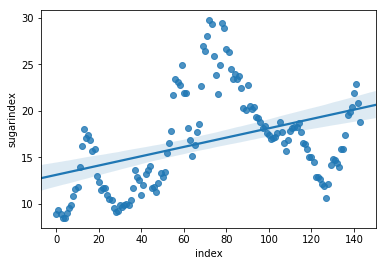

In [19]:
sns.regplot(x="index", y="sugarindex", data=df)

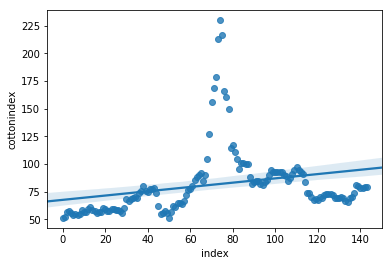

In [20]:
sns.regplot(x="index", y="cottonindex", data=df)

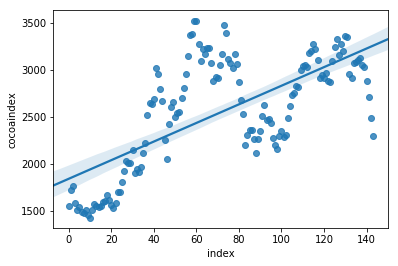

In [21]:
sns.regplot(x="index", y="cocoaindex", data=df)

Although we can clearly see the positive correlation between our commodity prices and the number of months since January 2005, the prices are extremely cyclical, and these cycles span many months or years. Interestingly, we can see the commodity prices spike between 36 and 84 months since January 2005, which translates to 2008-2012 — the years of the Great Recession.

Having visually confimed the connection between commodity prices and time since January 2005, we then try to identify any correlation between these commodity prices and the degree of deviation from the mean temperature between 1950 and 1980.

### iii. Relationship between Commodity Prices and Mean Temperature Deviation

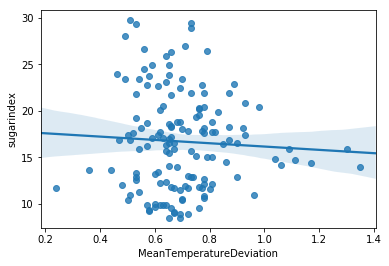

In [22]:
sns.regplot(x="MeanTemperatureDeviation", y="sugarindex", data=df)

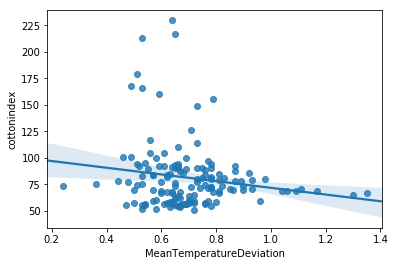

In [23]:
sns.regplot(x="MeanTemperatureDeviation", y="cottonindex", data=df)

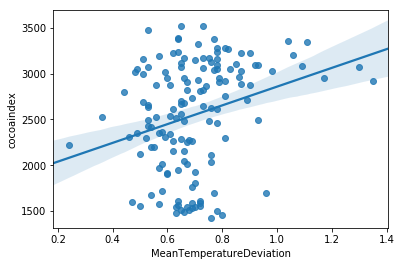

In [24]:
sns.regplot(x="MeanTemperatureDeviation", y="cocoaindex", data=df)

### iv. Discussion

As we can see, the connection between Mean Temperature Deviation and global commodity prices is largely zero or leaning negative. We recognize that commodity prices are affected by far more factors than simply the weather, however, and thus view these results as insignificant due to the sheer amount of noise that can affect the data.

However, we also decided to run a regression to confirm the lack of a relationship between commodity prices and Mean Temperature Deviation.

### v. Further Regression

In [25]:
mod = sm.ols('sugarindex ~ MeanTemperatureDeviation', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             sugarindex   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.4338
Date:                Tue, 15 May 2018   Prob (F-statistic):              0.511
Time:                        00:11:25   Log-Likelihood:                -442.67
No. Observations:                 144   AIC:                             889.3
Df Residuals:                     142   BIC:                             895.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [26]:
mod = sm.ols('cottonindex ~ MeanTemperatureDeviation', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            cottonindex   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     4.006
Date:                Tue, 15 May 2018   Prob (F-statistic):             0.0472
Time:                        00:11:25   Log-Likelihood:                -696.33
No. Observations:                 144   AIC:                             1397.
Df Residuals:                     142   BIC:                             1403.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [27]:
mod = sm.ols('cocoaindex ~ MeanTemperatureDeviation', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             cocoaindex   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     11.95
Date:                Tue, 15 May 2018   Prob (F-statistic):           0.000721
Time:                        00:11:26   Log-Likelihood:                -1118.4
No. Observations:                 144   AIC:                             2241.
Df Residuals:                     142   BIC:                             2247.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

As predicted, the correlations we observe are next to useless. Perhaps completely useless. The R-squared values, once again, are spectacularly low, and imply that the correlation is statistically insignificant. 

## IV. Findings and Concluding Remarks

From our data analysis, we can see that there is very little relationship between commodity prices, commodity futures trading volumes, and average global temperature deviations from the 1950-1980 mean (our proxy for quantifying climate change).

Even when considering the correlations between these variables in different scenarios, statistical analysis reveals that such correlations are not significant, and that they definitely do not fully explain changes in each other. Again, this makes sense because there are countless factors and risks that can affect these variables, whether the factors are political, social, economic, or environmental in nature. This is also due in part to the fact that the geographic location in which agricultural activity occurs is quite literally the entire world. 

Perhaps if we had more focused data, such as commodity prices in the United States and futures trading volumes of American agricultural firms, we would be able to reach more productive conclusions. However, such granular data is nigh-impossible to obtain with the budget of an undergraduate, assuming such data even exists and is organized for analytical use. 

In short, our data was likely too noisy due to its wide coverage of the world, and we found no statistically significant relationships between any of our factors, even when adjusting for market inefficiencies.